# News Article Classification: Comparing Bag of N-gram Models

*By: Aman Barot*

**Objective**  

Train and evaluate multiple n-gram based baseline models to classify news articles from the AG News dataset into four classes (World, Sports, Business, Sci/Tech). Compare performance across different approaches and analyze top contributing features per class for the best models.

**Models Evaluated**
The models are built using XGBoost and with four different sets of features:
- Counts of Unigrams
- Counts of Unigrams + Bigrams
- TF-IDF of Unigrams
- TF-IDF of Unigrams + Bigrams

**Steps**
1. Load and preprocess the AG News dataset
2. Vectorize text using different n-gram strategies
3. Train XGBoost across all variants
4. Evaluate using classification metrics (accuracy, macro F1)
5. Visualize comparative performance
6. Analyze and visualize feature importance for the best model

**Outcomes** 
- Identified that counts of unigrams performs best on AG News dataset
- **Top unigram features** per class. 
    - **World**: iraq, kill, palestenian, minister, press, iraqi, president, baghdad, hostage, militant
    - **Sports**: coach, game, team, cup, win, sports, league, company, victory, championship
    - **Business**: price, oil, profit, stock, company, billion, percent, sale, airlines, bank
    - **Sci/Tech**: microsoft, software, nasa, space, internet, web, computer, scientist, linux, online
- **Text Classification Trade-offs**:
    - **Unigrams**: 
        - **Pros**: Simple, interpretable, and robust.
        - **Cons**: Sparse, misses context.
        - **Use Case**: Basic models where simplicity is key.

    - **Bigrams**: 
        - **Pros**: Captures short phrases, better context.
        - **Cons**: Increased dimensionality, risk of overfitting.
        - **Use Case**: When context matters (but we want to be careful to avoid overfitting).

    - **TF-IDF**: 
        - **Pros**: Downweights common words, improves generalization.
        - **Cons**: Loses raw frequency signal.
        - **Use Case**: Focuses on meaningful terms.

    - **Count-based**: 
        - **Pros**: Retains word frequency.
        - **Cons**: Overemphasizes common words.
        - **Use Case**: Useful when frequency is important.

    -  Model Complexity, Interpretability, and Performance:
        - **Complexity**: Larger n-grams (bigrams, etc.) increase dimensionality and computational cost.
        - **Interpretability**: Unigrams are easy to interpret; bigrams and TF-IDF are more abstract.
        - **Performance**: TF-IDF and bigrams improve performance but risk overfitting; unigrams are simpler but less context-sensitive.


## Table of Contents
1. [Dataset Description](#dataset-description)
2. [Getting Data](#get-data)
3. [Preprocessing Data](#data-cleaning)
4. [Feature Creation](#generating-features)
5. [Building and Comparing Models](#training-xgboost-models-and-comparing-on-validation-set)
6. [Top Features by News Article Type](#shap-importance-for-best-model)
7. [Performance of Best Model on Test Set](#evaluating-best-model-on-test-set)

In [29]:
from datasets import load_dataset, DatasetDict
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report,
)
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import shap
from matplotlib import pyplot as plt 
import importlib

In [30]:
import preprocess
import hyperparam_tune
import skopt_hyperparam_tune

In [50]:
# importlib.reload(preprocess)
# importlib.reload(hyperparam_tune)
importlib.reload(skopt_hyperparam_tune)

<module 'skopt_hyperparam_tune' from '/Users/box/Documents/Projects/nlp_code_samples/skopt_hyperparam_tune.py'>

## Dataset Description

The **AG News** dataset is a large-scale collection of news articles, primarily used for **text classification** tasks. The dataset consists of news articles classified into four categories:

1. **World** – News related to international events, politics, and general world affairs.
2. **Sports** – Articles covering various sports topics, including scores, player statistics, and event coverage.
3. **Business** – Articles discussing economics, finance, companies, and the stock market.
4. **Science/Technology** – Articles focused on technological advancements, science discoveries, and related fields.

The dataset was originally collected and made available by the **AG (Academia Sinica)** to facilitate text classification research. It is widely used as a benchmark in machine learning for evaluating classification algorithms and models.

#### Key Features:
- **Training Set**: 120,000 labeled samples
- **Test Set**: 7,600 labeled samples
- **Text Content**: Each article contains a headline and a brief summary of the news topic.
- **Class Distribution**: The dataset has a balanced distribution of articles across the four categories.


## Getting Data


The following code gets the data using the Hugging Face's dataset library. The dataset is of type `DatasetDict` and has two data partitions as training set and test set. 
The training data is further split into a smaller training set and a validation set. The validation set is chosen to be of the same size as the test set. The validation is used for model selection, early stopping (in case of XGBoost), and for tuning any hyperparameters.
The three data splits are stored in a `DatasetDict` to easily map the preprocessing pipeline onto all the data splits in one go. It ensures that the same preprocessing steps are applied to all the data splits, and they are applied in identical order.

In [32]:
data_orig = load_dataset("ag_news")
valid_size = len(data_orig['test'])
# Split train set into train and validation set
train_valid_split = data_orig["train"].train_test_split(
    test_size=valid_size, shuffle=True, seed=42
)
data_updated = DatasetDict({
    "train": train_valid_split["train"],
    "valid": train_valid_split["test"],
    "test": data_orig["test"],
})

In [33]:
for split in data_updated:
    print(f"{split}: {len(data_updated[split])}")

train: 112400
valid: 7600
test: 7600


Class labels are equally distributed in the training set.

In [34]:
Counter(data_updated["train"]['label'])

Counter({2: 28206, 1: 28089, 0: 28070, 3: 28035})

## Data Cleaning

The following **data preprocessing operations** are applied on the datasets (identically on all three data splits).

1. Tokenization into words and converting words to lower case.
2. Extracting lemma for each word. This helps with feature reduction and model generalization for bag of words and bag of $n$-gram models. 
    - Also, only the alphabetical lemmas are kept i.e., numbers, punctuations, links, and special characters are removed. 
    - Tokens with hyphens and contractions are also removed.
3. Stop words are removed. This ensures the model predicts on contextual words and consequently is more interpretable and generalizable. In addition to using stop words from `spacy`, I also the following:
    + Names of days such as monday, tuesday, yesterday etc.
    + Names of news entities such as Reuters and AP to prevent model from associating a news agency with a news type.
4. HTML special characters are unescaped. For example, 
    - `&amp;` is converted to &,
    - `&lt;` is converted to <, and
    - `&gt;` is converted to >.
5. Text is standardized so that the two tokens new and york are combined into one token newyork.
6. Strings such as "(AEOS.O: Quote, Profile, Research)" are common is business texts in this dataset. These provide the stock ticker and links to stock quote, profile and research. These are cleaned from the data to prevent model from learning that quote, profile, research, and their bigrams are business specific terms.

In [35]:
data_updated = data_updated.map(
    preprocess.tokenize_lemmatize_filter_ents,
    batched=True,
    batch_size=1000,
    num_proc=6,
    fn_kwargs={'stop_words': list(preprocess.CUSTOM_STOP_WORDS)}
    )

In [36]:
train = data_updated['train']
valid = data_updated['valid']
test = data_updated['test']

## Generating Features

I create four arrays towards the four kinds of models I will build and compare. The description is as follows:
1. Counts of unigrams
2. Counts of unigramns and bigrams
3. TF-IDF on unigrams
4. TF-IDF on unigrams and bigrams

The arrays and models will have the numbering above to maintain consistency in notation.

In [37]:
MAX_FEATURES = 10_000
vectorizers = {}
# Create vectorizers for different n-gram ranges and methods
vectorizers[1] = CountVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1,1),
)
vectorizers[2] = CountVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1,2),
)
vectorizers[3] = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1,1),
)
vectorizers[4] = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=(1,2),
)

The following creates features for train and validation sets for each of the models.

In [38]:
feats = {}
for i in range(1, 5):
    feats[f"{i}_train"] = vectorizers[i].fit_transform(
        [' '.join(tokens) for tokens in train['cleaned_tokens']]
    )
    feats[f"{i}_valid"] = vectorizers[i].transform(
        [' '.join(tokens) for tokens in valid['cleaned_tokens']]
    )

## Training XGBoost Models and Comparing on Validation Set

Hyperparameters used for training all the models. These are baseline hyperparameters and no tuning is done to compare the models. Once I select the best model, I will tune the hyperparameters for the same before evaluating on the test set.

In [39]:
default_params = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'early_stopping_rounds': 10, 
    'n_estimators': 1000, 
}

Creating dataframe to store evaluation metrics

In [40]:
eval_metrics = pd.DataFrame(
    columns=['method', 
             'accuracy', 
             'macro_f1', 
             'macro_precision',
             'macro_recall',],
    index=range(1, 5)
)
eval_metrics['method'] = [
    'Count 1-gram', 
    'Count 1-2-gram', 
    'TF-IDF 1-gram', 
    'TF-IDF 1-2-gram'
]

Training and evaluation models

In [41]:
models = {}
for i in range(1, 5):
    X_train = feats[f"{i}_train"]
    X_valid = feats[f"{i}_valid"]
    
    xgb_model = xgb.XGBClassifier(**default_params)
    xgb_model.fit(
        X_train, 
        train['label'],
        eval_set=[
            (X_valid, valid['label'])
            ],
        verbose=0,
    )
    models[i] = xgb_model
    # Compute evaluation metrics
    y_pred = xgb_model.predict(X_valid)
    accuracy = accuracy_score(valid['label'], y_pred)
    macro_f1, macro_precision, macro_recall, _ = precision_recall_fscore_support(
        valid['label'], 
        y_pred, 
        average='macro'
    )
    eval_metrics.loc[i, 'accuracy'] = accuracy
    eval_metrics.loc[i, 'macro_f1'] = macro_f1
    eval_metrics.loc[i, 'macro_precision'] = macro_precision
    eval_metrics.loc[i, 'macro_recall'] = macro_recall

In [42]:
eval_metrics

,method,accuracy,macro_f1,macro_precision,macro_recall
1,Count 1-gram,0.903158,0.902648,0.902904,0.902544
2,Count 1-2-gram,0.903158,0.90256,0.902886,0.902525
3,TF-IDF 1-gram,0.898158,0.897684,0.89793,0.897575
4,TF-IDF 1-2-gram,0.899605,0.899158,0.89944,0.899063


## SHAP Importance for Best Model

As we saw above, the counts of unigrams performs the best and is also the simplest of the four models. I now compute the following the top positive features (unigrams) for each of the classes. These are unigrams are most important identifiers of each of the classes.

In [43]:
explainer_1 = shap.TreeExplainer(models[1])
shap_vals_1 = explainer_1.shap_values(feats['1_valid'])

In [44]:
pos_pred_1 = pd.DataFrame({
    'feat_name': vectorizers[1].get_feature_names_out(),
})
for i in range(4):
    mask = (np.array(valid['label']) == i)
    pos_pred_1['label_' + str(i)] = \
        np.mean(shap_vals_1[mask,:,i], axis=0) * 100

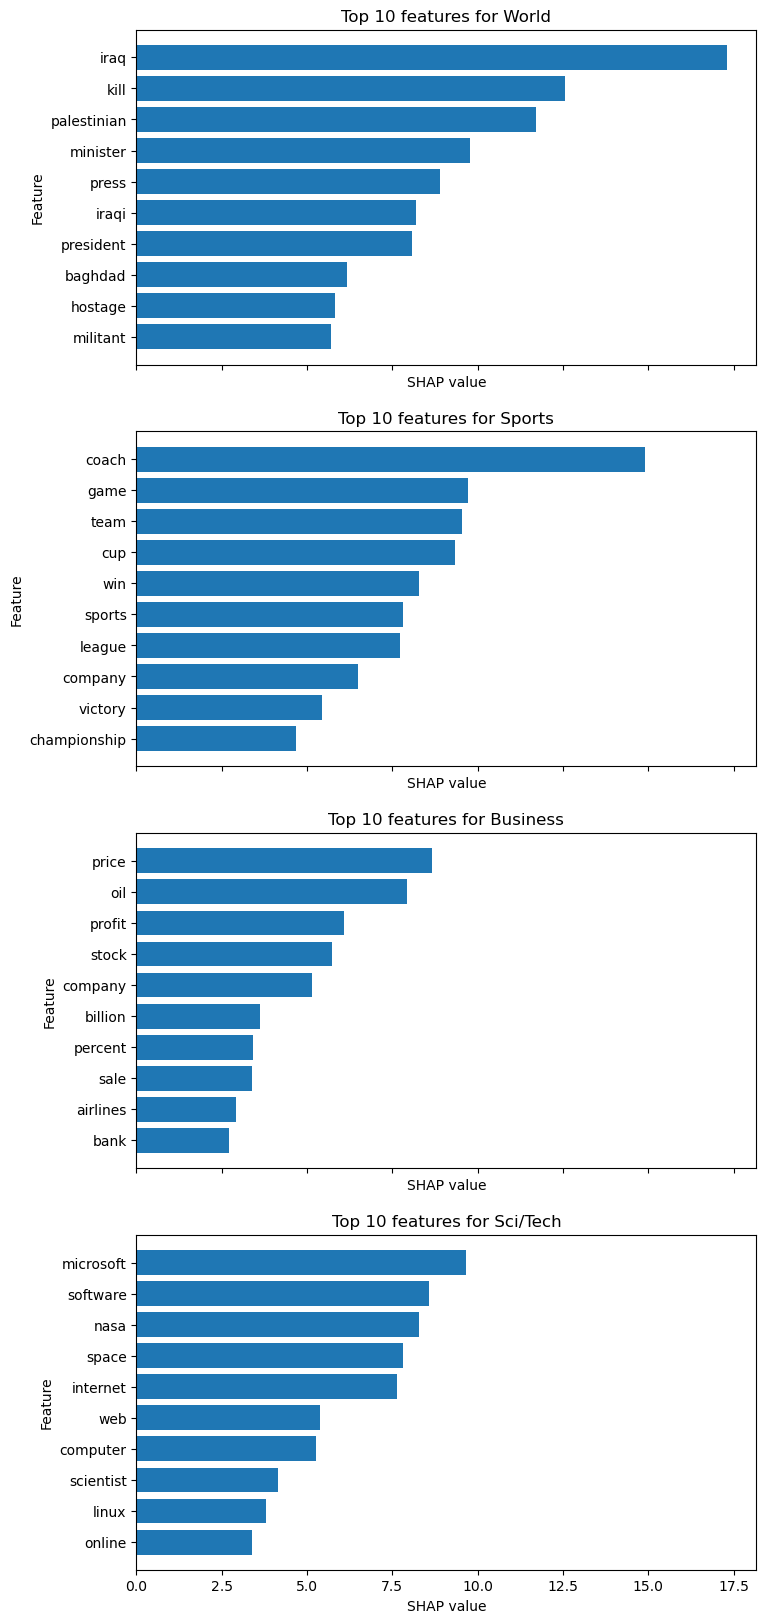

In [45]:
class_labels = train.features['label'].names
fig, ax = plt.subplots(
    4, 1, 
    figsize=(8, 20),
    sharex=True,
)
for i in range(4): 
    ax[i].barh(
        pos_pred_1.sort_values(
            by='label_' + str(i), 
            key=abs,
            ascending=False)['feat_name'].iloc[0:10],
        pos_pred_1.sort_values(
            by='label_' + str(i), 
            key=abs,
            ascending=False)['label_' + str(i)].iloc[0:10],
    )
    ax[i].invert_yaxis()
    ax[i].set_title(f'Top 10 features for {class_labels[i]}')
    ax[i].set_xlabel('SHAP value')
    ax[i].set_ylabel('Feature')

## Bayesian Hyperparameter Optimization and Evaluating Best Model on Test Set

I first **tune hyperparameters using Bayesian methods** to select the best model using train set (and valid set for evaluating choices of hyperparam and early stopping) only.

In [51]:
best_model, best_params, best_logloss_score = \
    skopt_hyperparam_tune.tune_xgb(
        X_train=feats['1_train'],
        y_train=train['label'],
        X_valid=feats['1_valid'],
        y_valid=valid['label'],
        num_classes=4,
        n_calls=50,
    )

Best parameters: {'learning_rate': 0.3048555732450578, 'max_depth': np.int64(12), 'min_child_weight': 1.0, 'gamma': 0.0, 'reg_alpha': 0.5629452942690799, 'reg_lambda': 0.24451880642256957}


With the best model selected, I compute its **performance on the test set**.

In [52]:
feats['1_test'] = vectorizers[1].transform(
    [' '.join(tokens) for tokens in test['cleaned_tokens']]
)
class_labels = train.features['label'].names
y_test_pred = best_model.predict(feats['1_test'])
test_accuracy = accuracy_score(test['label'], y_test_pred)
test_macro_f1, test_macro_precision, test_macro_recall, _ = \
    precision_recall_fscore_support(
        test['label'], 
        y_test_pred, 
        average='macro'
    )
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Macro F1: {test_macro_f1:.4f}")
print(f"Test Macro Precision: {test_macro_precision:.4f}")
print(f"Test Macro Recall: {test_macro_recall:.4f}")
# classification report
print("Classification Report:")
print(classification_report(
    test['label'], 
    y_test_pred, 
    target_names=class_labels
    ))

Test Accuracy: 0.9072
Test Macro F1: 0.9072
Test Macro Precision: 0.9072
Test Macro Recall: 0.9070
Classification Report:
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      1900
      Sports       0.94      0.98      0.96      1900
    Business       0.87      0.88      0.87      1900
    Sci/Tech       0.89      0.88      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



The model created using unigram counts has a macro F1 score of **0.91**.